In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from helpers.readers import prepare_dataframes
from scipy.sparse.csgraph import reverse_cuthill_mckee

In [2]:
movies, directors, awards = prepare_dataframes()

Preprocess logs:
✅ Fixed Movie Languages inside Movie Countries
✅ Removed Deseret characters
✅ Movie release date splitted to three columns: Movie release Year, Movie release Month, Movie release Day
✅ Fixed 'Hunting Season' release year 1010 => 2010
✅ Seperated freebase identifiers from Movie Languages, Movie Countries and Movie Genres
✅ Replaced Hariyani with Haryanvi
✅ Replaced Saami with Sami
✅ The Flying Scotsman (1929 film) country fix
✅ Ukranian SSR fix
✅ Palestinian territories fix
✅ Fixed huge runtimes
✅ Removed series
Preprocess logs:
✅ Moved genres from runtimeMinutes to genres column
Preprocess logs:
✅ Aligned bad rows


# Get scores for movies and directors

In [3]:
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

In [4]:
def metric(director):
    directed_movies = movies[movies.directors.str.contains(director.name)]
    score = {
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score

# Apply the metrics on one column (nested)
directors['score'] = directors.apply(metric, axis=1)

# Put the socres in different columns
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

# Drop the extra column
directors.drop('score', axis=1, inplace=True)

# Look at the director scores temporally

In [5]:
genres = []
for item in movies.dropna(subset='genres').genres.str.split(','):
    genres.extend(item)
genres = set(genres)

print(f'We have {len(genres)} genres.')

We have 364 genres.


In [6]:
genres = []
for item in movies.dropna(subset='genres_imdb').genres_imdb.str.split(','):
    genres.extend(item)
genres = set(genres)

print(f'We have {len(genres)} genres.')

We have 28 genres.


We go on with the IMDb genres since they seem to be more general (only 28) than the CMU genres.

In [7]:
def get_genres(movies):
    """Returns a dataframe with a row for each genre in each released movie."""

    directed_genres = []
    for _, movie in movies.iterrows():
        if isinstance(movie.genres_imdb, str):
            directed_genres.extend([(movie.release, g) for g in movie.genres_imdb.split(',')])

    gs = pd.DataFrame(directed_genres).rename(columns={0: 'release', 1: 'genre'})
    if len(gs):
        gs['isNew'] = gs.apply(lambda row: row.genre not in gs.query('release < @row.release').genre.tolist(), axis=1)

    return gs


In [8]:
def avgtop(movies, n=3):
    """Returns the avg-n score from a list of movies."""

    if len(movies.score.dropna()) < n:
        return pd.NA
    else:
        return movies.score.sort_values(ascending=False)[:n].mean()

In [9]:
def metric_ts(metric, movies, **kws):
    """Returns a metric from a list of movies as a timeseries."""

    ts = pd.DataFrame([
        (year, metric(movies[movies.release <= year], **kws))
        for year in movies.release.unique().tolist()
    ])
    ts = ts.rename(columns={0: 'release', 1: 'score'}).dropna()

    return ts

In [10]:
def plot_genre_evolution(director):
    fig, ax = plt.subplots(figsize=(18, 4))

    # Get list of directed movies
    directed_movies = movies[movies.directors.str.contains(director.name)]

    # Plot genre histogram
    sns.histplot(
        ax=ax,
        data=get_genres(directed_movies),
        x='release',
        y='genre',
        discrete=(True, True),
        hue='isNew',
        # color='#4CB391',
    )

    axright = ax.twinx()
    # Plot score evolution
    sns.lineplot(
        ax=axright,
        data=metric_ts(avgtop, directed_movies, n=3),
        x='release',
        y='score',
        color='black',
        marker='o',
        label='top-3 score average',
    )
    # Plot score per movie
    sns.lineplot(
        ax=axright,
        x=directed_movies.dropna(subset=['score', 'release']).release.astype(float),
        y=directed_movies.dropna(subset=['score', 'release']).score,
        color='black',
        marker='X',
        label='single release score',
    )

    ax.grid()
    ax.set(title=director.primaryName)
    axright.legend(loc='lower center')
    ax.set_xticks(directed_movies.release.unique().tolist())
    ax.set_xticklabels(directed_movies.release.unique().tolist(), rotation='vertical')
    plt.tight_layout()
    plt.show()

    return fig

We can look at the style evolution of a single person using the `plot_genre_evolution` plot:

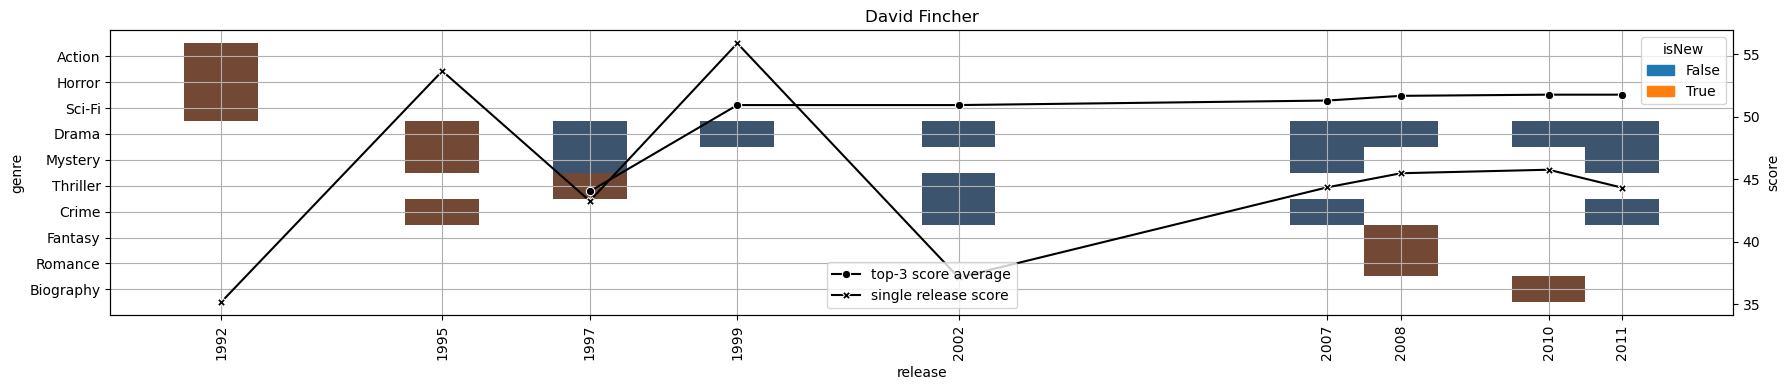

In [11]:
_ = plot_genre_evolution(directors.loc['nm0000399'])

Let's extend the movies dataframe and add two columns:

- `directorNewGenre`: Whether the director explored a new genre in this movie
- `directorCareerYears`: Years passed in the director's career at the release time of the movie

In [12]:
movies['directorNewGenre'] = False
movies['directorCareerYears'] = pd.NA


for nconst in tqdm.tqdm(directors.index):
    # Get movies directed by this director
    director_movies = movies[movies.directors.str.contains(nconst)]

    # Add the years passed after beginning the career of the director
    if not len(director_movies):
        continue
    directorCareerYears = director_movies.release.astype(float) - director_movies.release.min()
    movies.directorCareerYears.update(other=directorCareerYears)

    # Add whether a new genre is explored by the director in this movie
    director_genres = get_genres(director_movies)
    if not len(director_genres):
        continue
    directorNewGenre = director_movies.dropna(subset=['genres_imdb', 'release']).apply(lambda row: director_genres.query('release == @row.release').isNew.any(), axis=1)
    movies.directorNewGenre.update(other=directorNewGenre)


100%|██████████| 28478/28478 [20:42<00:00, 22.92it/s]   


# Analyze the correlations

In [13]:
import statsmodels.formula.api as smf

Let's first add a column that determines whether the directors is considered as successful or not:

In [14]:
# movies.loc['tt1668191', 'release'] = 2010  # TODO: Clean in the beginning of the notebook

In [15]:
movies = movies.dropna(subset='directors').copy()
directors_successful = directors[directors['avg-3'] > 40].index.tolist()
movies['directorIsSuccessful'] = movies.apply(lambda row: any([d in directors_successful for d in row.directors.split(',')]), axis=1)

In [16]:
movies_ = movies.copy()
movies_ = movies_.dropna(subset=['directorCareerYears', 'score']).query('directorCareerYears < 60')
movies_ = movies_.query('runtime > 20')  # Exclude short films
movies_ = movies_.query('runtime < 500')  # Exclude very long movies

In [17]:
movies_.directorCareerYears.fillna(movies_.directorCareerYears.mean(), inplace=True)
movies_.directorCareerYears = movies_.directorCareerYears.astype(float)
movies_.directorNewGenre = movies_.directorNewGenre.astype(int)

In [18]:
def normalize(s: pd.Series):
    return (s - s.mean()) / s.std()

movies_['runtimeNormalized'] = normalize(movies_.runtime)
movies_['directorCareerYearsNormalized'] = normalize(movies_.directorCareerYears)

A one-hot representation of the IMDb genres is very much sensible here.


## Correlation between a director’s critical success and evolution of their style regarding movie genres


Not easy to quantize "evolution of their style."

We can try to analyze the correlation between the `directorNewGenre` and the score of the movie

In [19]:
model = smf.ols('score ~ runtime + directorNewGenre + directorCareerYears', data=movies_.query('directorIsSuccessful == True')).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     192.2
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          8.26e-110
Time:                        22:40:00   Log-Likelihood:                -7385.6
No. Observations:                2052   AIC:                         1.478e+04
Df Residuals:                    2048   BIC:                         1.480e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              14.1431    

> Small but significant correlation between `directorNewGenre` and `score`.

> Large and significant correlation between `runtime` and `score`.

## To what extent do directors experiment with new genres and thematics over the course of their career, and is there a pattern of periods of experimentation followed by periods of consistency 



In [20]:
movies_.directorCareerYears.max()

59.0

In [21]:
print('*' * 100)
print('Correlations among all directors:')
print('*' * 100)
print(' ' * 100)
model = smf.ols('directorNewGenre ~  directorCareerYearsNormalized', data=movies_).fit()
print(model.summary())

print(' ' * 100)

print('*' * 100)
print('Correlations among successful directors:')
print('*' * 100)
print(' ' * 100)
model = smf.ols('directorNewGenre ~  directorCareerYearsNormalized', data=movies_[movies_.directorIsSuccessful]).fit()
print(model.summary())
print(' ' * 100)

****************************************************************************************************
Correlations among all directors:
****************************************************************************************************
                                                                                                    
                            OLS Regression Results                            
Dep. Variable:       directorNewGenre   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                 1.397e+04
Date:                Mon, 18 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:40:00   Log-Likelihood:                -26800.
No. Observations:               50648   AIC:                         5.360e+04
Df Residuals:                   50646   BIC:                         5.362e+04
Df Model:                      

> Intercept: Probability of exploring a new genre in a movie with average years through the career.

> Coefficient: Increase in probability with 1 std (~10 years) more through the career.

> There is a negative correlation.

The negative correlation might be due to the fact that in the first years, every genre is considered a new genre.

Let's do the same analysis considering only movies after a decade through the career of the directors.

In [22]:
model = smf.ols('directorNewGenre ~  directorCareerYearsNormalized', data=movies_.query('directorCareerYears > 10')).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       directorNewGenre   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     512.6
Date:                Mon, 18 Dec 2023   Prob (F-statistic):          9.68e-112
Time:                        22:40:00   Log-Likelihood:                -11129.
No. Observations:               15996   AIC:                         2.226e+04
Df Residuals:                   15994   BIC:                         2.228e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

<Axes: xlabel='directorCareerYears', ylabel='directorNewGenre'>

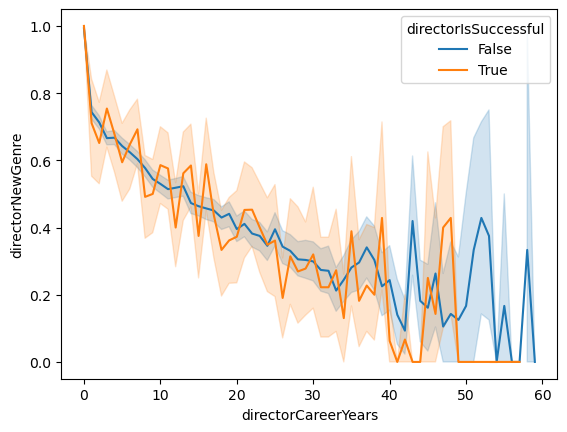

In [23]:
sns.lineplot(
    data=movies_,
    x='directorCareerYears',
    y='directorNewGenre',
    hue='directorIsSuccessful'
)

> Not surprisingly, there is general trend of less tendency to try a new genre as the years pass in a director's career.

## Are directors who tend to work on more diverse projects less successful or more successful?

We can identify these directors by looking at the number of genres that .

In [46]:
def get_num_genres(director):
    # Get movies directed by this director
    director_movies = movies[movies.directors.str.contains(director.name)]
    return int(director_movies.directorNewGenre.sum())

def get_avg_num_genres_per_movie(director):
    # Get movies directed by this director
    director_movies = movies[movies.directors.str.contains(director.name)]
    return director_movies.genres_imdb.dropna().str.split(',').apply(len).mean()

In [47]:
directors['genresPerMovie'] = directors.apply(get_avg_num_genres_per_movie, axis=1)
directors['genresExplored'] = directors.apply(get_num_genres, axis=1)

In [115]:
directors_ = directors.copy()
directors_ = directors_.dropna(subset=['avg-3', 'genresExplored'])
directors_ = directors_.rename(columns={'avg-3': 'avg3',})
directors_.avg3 = directors_.avg3.astype(int)

In [64]:
model = smf.ols('avg3 ~  genresExplored', data=directors_).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   avg3   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     544.0
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          1.26e-115
Time:                        21:02:12   Log-Likelihood:                -22469.
No. Observations:                6508   AIC:                         4.494e+04
Df Residuals:                    6506   BIC:                         4.496e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         19.1272      0.133    144.

In [65]:
model = smf.ols('avg3 ~  genresPerMovie', data=directors_).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   avg3   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     1058.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          3.67e-215
Time:                        21:02:17   Log-Likelihood:                -22226.
No. Observations:                6505   AIC:                         4.446e+04
Df Residuals:                    6503   BIC:                         4.447e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.8774      0.393     22.

In [66]:
model = smf.ols('avg3 ~ genresPerMovie + genresExplored', data=directors_).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   avg3   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     802.2
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          4.00e-312
Time:                        21:03:19   Log-Likelihood:                -21999.
No. Observations:                6505   AIC:                         4.400e+04
Df Residuals:                    6502   BIC:                         4.402e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.8017      0.382     20.

/opt/miniconda/envs/dummy/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


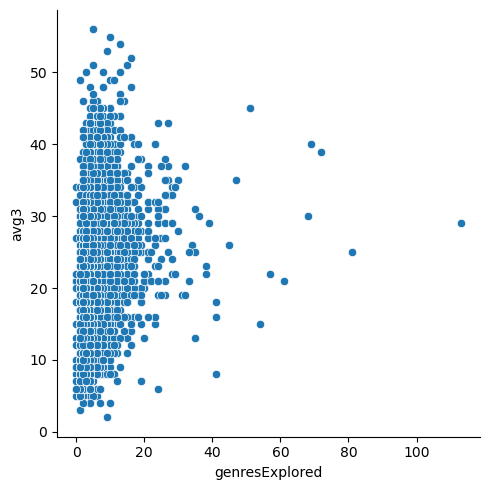

In [121]:
sns.relplot(data=directors_, kind='scatter', x='genresExplored', y='avg3')


/opt/miniconda/envs/dummy/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


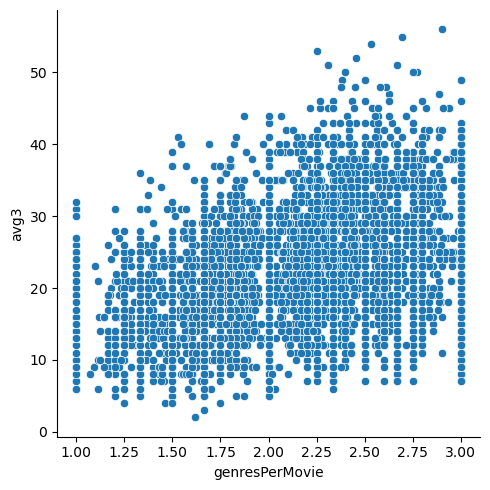

In [120]:
sns.relplot(data=directors_, kind='scatter', x='genresPerMovie', y='avg3')

> Doesn't really look like a meaningful correlation

In [73]:
model = smf.ols('awardsNominated ~ genresPerMovie + genresExplored', data=directors_).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        awardsNominated   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     16.60
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           6.47e-08
Time:                        21:07:29   Log-Likelihood:                -31158.
No. Observations:                6505   AIC:                         6.232e+04
Df Residuals:                    6502   BIC:                         6.234e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.7994      1.563      5.

> Nothing interesting, very low R-squared.

In [74]:
model = smf.ols('awardsWon ~ genresPerMovie + genresExplored', data=directors_).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              awardsWon   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.19
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           1.91e-06
Time:                        21:07:56   Log-Likelihood:                -26248.
No. Observations:                6505   AIC:                         5.250e+04
Df Residuals:                    6502   BIC:                         5.252e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.4011      0.735      7.

> Nothing interesting, very low R-squared.

In [123]:
directors_['isSuccessful'] = (directors_.avg3 > 40).astype(int)
model = smf.ols('isSuccessful ~ genresPerMovie + genresExplored', data=directors_).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           isSuccessful   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     54.45
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           3.54e-24
Time:                        21:25:19   Log-Likelihood:                 4359.3
No. Observations:                6505   AIC:                            -8713.
Df Residuals:                    6502   BIC:                            -8692.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0405      0.007     -6.

> Again, very small coefficient, let's accept that there is not any correlation.

## Is it less likely or more likely for a movie to succeed when the director tries a new genre?

We know that many cofounders might exist. However, let's first check if there is a correlation:

In [127]:
model = smf.ols('score ~ directorNewGenre + directorCareerYears', data=movies_).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     699.3
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          2.71e-300
Time:                        21:30:46   Log-Likelihood:            -1.7364e+05
No. Observations:               50648   AIC:                         3.473e+05
Df Residuals:                   50645   BIC:                         3.473e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              17.4729    

In [ ]:
# TODO: Do matching and causal analysis

## Are more successful directors more often specialized in a certain combination of genres ?

### Define algorithms and functions

In [807]:
def get_bipartite_graph(movies, genres=None, directors=None):
    """Creates a tripartite graph with directors, movies, and genres."""

    # Drop NAs
    movies = movies.dropna(subset='genres_imdb')

    # Get all the genres
    if genres is None:
        genres = []
        for x in movies.genres_imdb.str.split(',').dropna(): genres.extend(x)

    # Get all the directors
    if directors is None:
        directors = []
        for x in movies.directors.str.split(',').dropna(): directors.extend(x)

    # Create the graph
    G = nx.Graph()
    for tconst, movie in movies.iterrows():
        G.add_node(tconst, part=0, n_genres=len(movie.genres_imdb.split(',')))
    G.add_nodes_from(set(genres), part=1)
    G.add_nodes_from(set(directors), part=2)
    nodes_movies = {n for n, d in G.nodes(data='part') if d == 0}
    nodes_genres = {n for n, d in G.nodes(data='part') if d == 1}
    nodes_directors = {n for n, d in G.nodes(data='part') if d == 2}
    for tconst, m in movies.iterrows():
        G.add_edges_from([(tconst, g) for g in m.genres_imdb.split(',')])
        G.add_edges_from([(tconst, d) for d in m.directors.split(',')])

    return G, nodes_movies, nodes_genres, nodes_directors

In [808]:
def draw_bipartite_graph(B, nodes_left, nodes_right):
    """Draws a bipartite graph."""

    pos = nx.bipartite_layout(G=B, nodes=nodes_left)
    nx.draw(G=B, with_labels=False, pos=pos, alpha=.5)
    nx.draw_networkx_labels(
        G=B,
        pos=pos,
        labels={n: n for n in nodes_right},
        font_size=12,
        font_color='k',
    )
    plt.show()

In [809]:
def draw_weighted_graph(G, layout = None, with_labels: bool = False, normalize_wights: bool = False):
    """Draws a weighted graph."""

    if layout is None:
        layout = nx.spring_layout(G)
    weights = list(nx.get_edge_attributes(G, 'weight').values())
    for (u, v, w) in G.edges(data='weight'):
        if normalize_wights:
            w = (w - min(weights)) / (max(weights) - min(weights))
        nx.draw_networkx_edges(G, layout, edgelist=[(u, v)], alpha=w)
    nx.draw_networkx_nodes(G, layout, nodelist=G.nodes)
    if with_labels:
        nx.draw_networkx_labels(G, layout)
    plt.show()

### Co-existence of genres for a group of directors

Let's project the bipartite graph on movies to find the connection between different genres.

In [ ]:
def get_genre_coexistence_graph(movies, directors):
    """Returns a weighted graph of genres based on their co-existence in movies of a set of directors."""

    # Get a tripartite graph
    B, _, nodes_genres, _ = get_bipartite_graph(
        movies=movies[movies.directors.str.split(',').apply(lambda ds: any([d in directors.index for d in ds]))],
        genres=None,
        directors=directors.index,
    )

    # Project the graph on movies
    MG = nx.bipartite.projected_graph(B, nodes_genres, multigraph=True)
    # Omit the directors
    MG = MG.subgraph(nodes_genres)

    # Reduce multiple edges to a weighted edge
    G = nx.Graph()
    G.add_nodes_from(nodes_genres)
    for u in nodes_genres:
        for v in nodes_genres:
            if u is v: continue
            G.add_edge(u, v, weight=MG.number_of_edges(u, v))

    return G

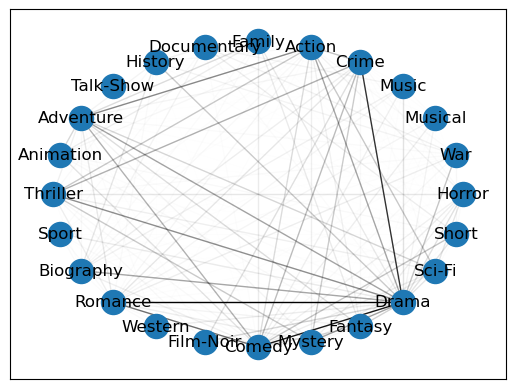

In [813]:
G = get_genre_coexistence_graph(
    movies=movies,
    directors=directors[directors['avg-3'] > 40],
)

layout = nx.circular_layout(G)
draw_weighted_graph(G, layout=layout, with_labels=True, normalize_wights=True)

> This can done in 3s, a very nice candidate for an interactive plot.

> It's not easy to compare the plot for successful directors vs. the others.

### Genre-similarity of a set of movies

Now, let's project the plot on genres and then get a similarity measure for directors:

In [805]:
def get_similarity_score(movies, directors):
    """
    Calculates a single similarity score of the movies of one or more directors
    based on the density of the projection graph.
    """

    # Get a tripartite graph
    B, nodes_movies, nodes_genres, _ = get_bipartite_graph(
        movies= movies[movies.directors.str.split(',').apply(lambda ds: any([d in directors.index for d in ds]))],
        genres=None,
        directors=directors.index,
    )

    # Project the graph on genres
    MG = nx.bipartite.projected_graph(B.subgraph(nodes_movies.union(nodes_genres)), nodes_movies, multigraph=True)

    # Reduce multiple edges to a weighted edge
    G = nx.Graph()
    G.add_nodes_from(nodes_movies)
    for u in nodes_movies:
        for v in nodes_movies:
            if u is v: continue
            max_num_edges = min([n for _, n in B.subgraph(nodes=[u, v]).nodes(data='n_genres')])
            w = MG.number_of_edges(u, v) / max_num_edges
            G.add_edge(u, v, weight=w)

    # Calculate the density of the weighted graph
    n = G.number_of_nodes()
    m = np.array(list(nx.get_edge_attributes(G, 'weight').values())).sum()
    score = 2 * m / (n * (n-1))

    return score

### Genre-similarity of a set of directors

In [814]:
def get_similarity_graph(movies, directors):
    """Creates a weighted graph of directors based on the similarity of their movie genres."""

    # Get the tripartite graph
    B, nodes_movies, nodes_genres, nodes_directors = get_bipartite_graph(
        movies=movies[movies.directors.str.split(',').apply(lambda ds: any([d in directors.index for d in ds]))],
        genres=None,
        directors=directors.index,
    )

    # Project the graph on genres (excluding the directors)
    MG = nx.bipartite.projected_graph(B.subgraph(nodes_movies.union(nodes_genres)), nodes_movies, multigraph=True)

    # Reduce multiple edges to a weighted edge
    G = nx.Graph()
    G.add_nodes_from(nodes_movies)
    for u in nodes_movies:
        for v in nodes_movies:
            if u is v: continue
            max_num_edges = min([n for _, n in B.subgraph(nodes=[u, v]).nodes(data='n_genres')])
            w = MG.number_of_edges(u, v) / max_num_edges
            G.add_edge(u, v, weight=w)

    # Make multigraph and add director nodes
    G = nx.MultiGraph(G)
    G.add_nodes_from(nodes_directors)

    # Remove movie nodes and create weighted edges between their directors
    for d in nodes_directors:
        for m in B[d].keys():
            for v, atts in G[m].items():
                # Continue if it's another movie of this director
                if v in B[d]: continue
                # Add the weighted edge otherwise
                w = atts[0]['weight']
                G.add_edge(d, v, weight=w)

    # Create the director's graph and add weighted edges
    D = nx.Graph()
    D.add_nodes_from(nodes_directors)
    for d1, d2 in [(d1, d2) for d1 in nodes_directors for d2 in nodes_directors]:
        if d1 == d2:
            continue
        sum_edges = np.array(list(nx.get_edge_attributes(G.subgraph([d1, d2]), 'weight').values())).sum()
        max_edges = len(B[d1]) * len(B[d2])
        w = sum_edges / max_edges if max_edges else 0
        D.add_edge(d1, d2, weight=w)

    return D

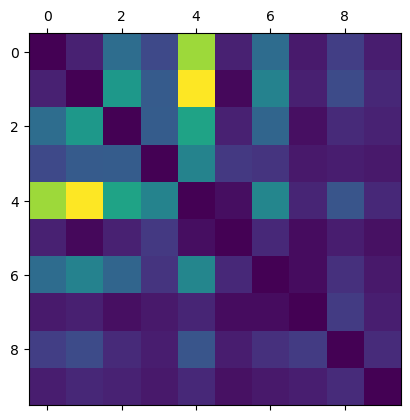

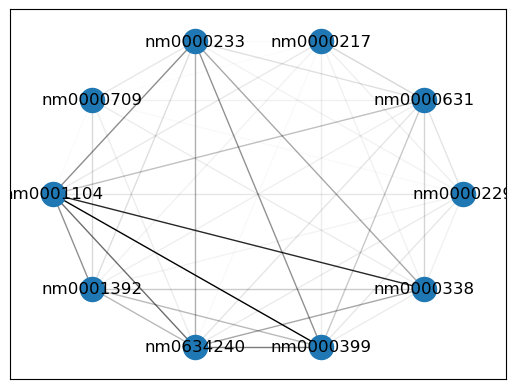

In [818]:
D = get_similarity_graph(
    movies=movies,
    directors=directors[directors['avg-3'] > 50],
)

# Plot the similarity matrix
similarity_matrix = nx.adjacency_matrix(D)
p = reverse_cuthill_mckee(similarity_matrix)
similarity_matrix = similarity_matrix.todense()
plt.matshow(similarity_matrix[:, p][p])

if len(D.nodes) < 20:
    plt.figure()
    layout = nx.circular_layout(D)
    draw_weighted_graph(D, layout=layout, with_labels=True, normalize_wights=True)